# Table of Contents:
* [Introduction](#Introduction)
 
 
* [1. Loading our Data](#1.-Loading-our-Data)
* [2. Creating Our CNN Model](#2.-Creating-Our-CNN-Model)
* [3. Training our Initial Model](#3.-Training-our-Initial-Model)
* [4. Evaluating Our Initial Model](#4.-Evaluating-Our-Initial-Model)
* [5. Modifying Our Model for Improvement](#5.-Modifying-Our-Model-for-Improvement)


* [Conclusion](#Conclusion)

# Introduction

In this notebook, we will take image data which has been collected in Notebook 1, cleaned, sorted, and balanced in notebook 2, and seperately utilized for our binary classification problem in notebook 3 in order to create a Convolutional Neural Network (CNN) model which predicts the classifications of skin lesions. In order to accomplish this task, we will need to load in our data through tensorflow and/or keras and create a CNN model which will set weights through training and, possibly, transfer learning. From this point, we will need to evaluate this model using our validation dataset and evaluate whether or not our model has performed well enough to consider it a successful model, or whether modifications must be made before considering it for making predictions on our testing dataset. Once we have a model which performs well enough to make testing predictions, we can further evaluate our model's performance using a number of metrics, particularly confusion matrices and classification reports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import shutil
from IPython.display import Image, display
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import cv2
import tensorflow as tf
from tensorflow.keras.metrics import CategoricalAccuracy
import keras
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# 1. Loading our Data

Next, it is time to use tensorflow and keras tools to load our previously cleaned, split and manipulated image data into forms which will be usable for our modeling. In order to accomplish this, we will be utilizing `image_dataset_from_directory`, the documentaion of which is available [here](https://keras.io/api/preprocessing/image/).

In [2]:
# We have 4 classes we are trying to classify
classes = 4

# They are colour images so they have 3 channels 
channels = 3

# We want to work with 50 images at a time (in each batch)
batch_size = 50

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = 'skin_train_2',
                                                    image_size=(75, 100),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    subset = 'training',
                                                    label_mode = 'categorical'
                                                   , seed = 42
                                                   , validation_split=15/85 )

Found 14052 files belonging to 4 classes.
Using 11573 files for training.


To manually check on our training data after the manipulations to our image data which we performed, we are able to read our training data as a numpy iterator to generate batches of data which we can visualize. If one wishes, they may take as many batches as they would like until they are convinced that their training data has been correctly manipulated and loaded in.

In [4]:
train_data_iterator = train_data.as_numpy_iterator()

In [5]:
batch = train_data_iterator.next()

In [6]:
batch[0].shape

(50, 75, 100, 3)

C:\Users\danie\anaconda3\envs\deeplearning\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


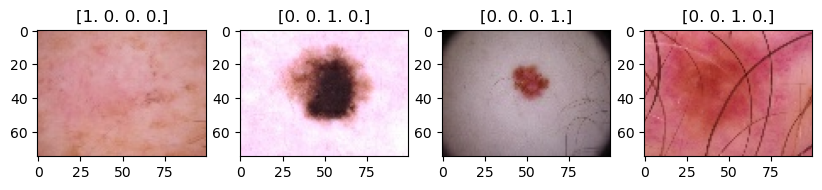

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

It is worth noting that these labels on our data, as are currently written with corressponding images, are not in a very human readable format. However, this will not be a problem for running our models, and so long as we are able to determine which label corresponds with which correct category for classification, there will be no issues moving forward.

In [8]:
train_data = train_data.map(lambda X, y: (X/255,y))

In [9]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(directory = 'skin_train_2',
                                                    image_size=(75, 100),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    subset = 'validation',
                                                    label_mode = 'categorical'
                                                   , seed = 42
                                                   , validation_split=15/85 )

Found 14052 files belonging to 4 classes.
Using 2479 files for validation.


In [10]:
validation_data = validation_data.map(lambda X, y: (X/255,y))

In [13]:
os.listdir('skin_train_2')

['Basal_Cell_Carcinoma',
 'Benign_Keratosis-like_Lesions',
 'Melanocytic_Nevi',
 'Melanoma']

In [11]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = 'skin_test_2',
                                                    image_size=(75, 100),
                                                    color_mode="rgb",
                                                    batch_size= 1413,
                                                    shuffle=False,
                                                    label_mode = 'categorical'
                                                   , seed = 42)

Found 1413 files belonging to 4 classes.


In [12]:
test_data = test_data.map(lambda X, y: (X/255,y))

Now that we have our training, testing, and validation data loaded in, and corresponding folders of images sorted, it is time to consider our CNN models to see which of our options work best for our data. In evaluating which CNN model works best, we will evaluate using the actual values confered by the file locations, as our keras model will interpret these directories as having their corressponding actual values. Additionally, we will not only store within our model history performance metrics on the training dataset, but more importantly, on our validation dataset which has not been used to establish our model's weights.

# 2. Creating Our CNN Model

As has been discussed in the creation of our previous models for our binary classification task in our previous notebook, a number of different types of layers were productive towards the successful classification of our data. One piece of valuable insight gained from our binary classification task is that our data responds well to the implimentation of dropout layers, and does not require transfer learning in order to create effective models with effective weights. For this reason, transfer learning will not be considered for this categorical classification task unless initial models suggest that it might be nessassary. Much of the following information on our convolutional layers utilized will be the same as from the previous notebook, but are equally relevant for this classification problem due to the similarity of the image data considered.

Below is a function which will create our initial model for binary classification. This is not the very first version of the model that I have run on this dataset, and incorporates a number of insights as to which kinds of convolutional layers are most useful, and where. The explanations of the different kinds of convolutions used, and the purpose which they accomplish for this classification task, are detailed below.

In [27]:
input_shape = (75, 100, 3)
def prepare_model(Transfer=None):
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu', input_shape=input_shape))            
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    model.add(Flatten())
    model.add(Dropout(0.5)) #adding this dropout layer helps to prevent overfitting. One good method
    # at our disposal of preventing overfitting is adding more dropout layers.
    model.add(Dense(4, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=[CategoricalAccuracy()])
    print(model.summary())
    return model

For the creation of our model, may different kinds of CNN convolutions have been considered and implimented. The first of these layers, and arguably the simplest, is our Conv2D layer which has been passed over our image data. For our model, we have utilized 3 Conv2D layers utilized throughout the model which, as they each accept a kernel size of 3x3, [perform element-wise multiplication](https://www.databricks.com/glossary/convolutional-layer) on our images in order to create outputs which are smaller in size for our other layers to utilize.

Our next utilized convolutional layer is MaxPooling2D, a convolution which downsamples its inputs according to convolutions by taking the [maximum value over an input window](https://keras.io/api/layers/pooling_layers/max_pooling2d/). This could be particularly practical for our data, as many of our most crucial information within our input data is the skin lessions themselves, which will typically have higher values than the (lighter) skin around them. This layer can help to identify which portions of an image might be most crucial for classification.

One kind of CNN Layer which is utilized throughout our modeling for slightly different purposes are Dense layers. Dense layers are layers which will generate a [weighted average of the previous layer](https://towardsdatascience.com/introduction-to-convolutional-neural-network-cnn-de73f69c5b83) into a 1-dimensional array. One use of dense layers in our inital model is the last use of a dense layter in our model which, with the hyperparameter 4 chosing between 4 classes and an activation of softmax, informs our model to choose between our 4 categories before it returns so that our model will make a decision about which class it is predicting out of the number of classes which it has available.

Dropout layers, as discussed at [this link](https://www.baeldung.com/cs/ml-relu-dropout-layers), which is also the source of the visualization below, have proven to be highly effective in preventing model overfitting on this dataset. To begin with, we will utilize a single dropout layer. But, if the model seems to be overfitting with one dropout layer, we may wish to add additional dropout layers or to change our dropout perameter. First, however, we should consider how well our model seems to be overfitting with a single dropout layer.

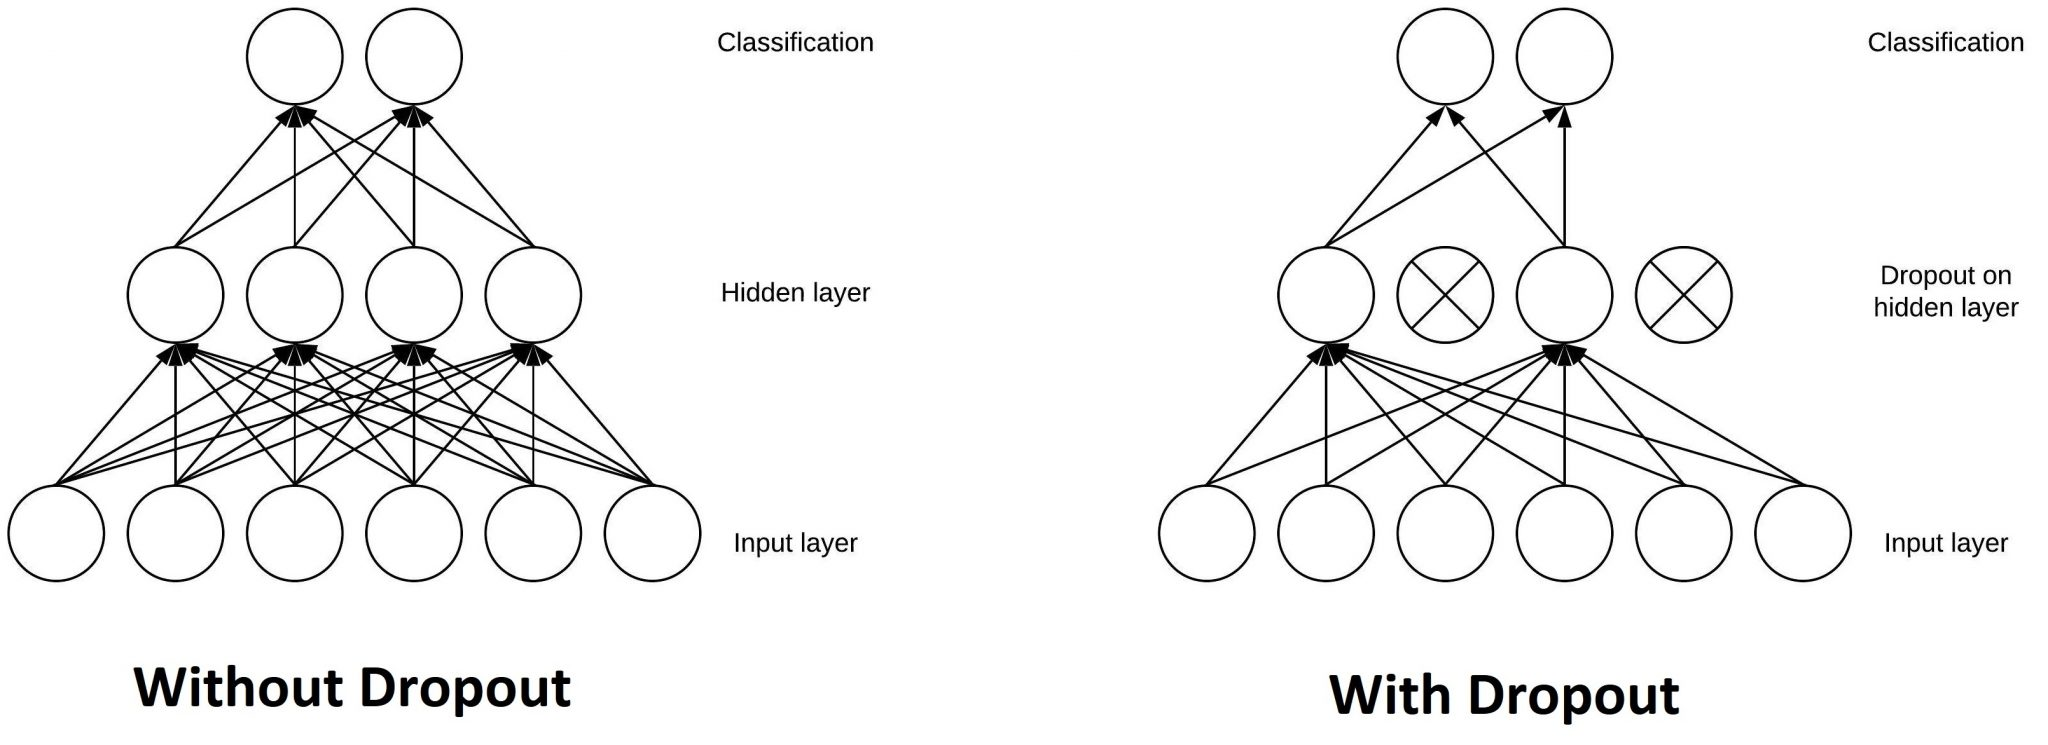

During the earliest instances of modeling on our data, dropout layers were not utilized at all. For these models, overfitting occured very frequently on our training dataset, and could usually be seen as a significant problem even within the first ten epochs of model training. This was significantly mitigated through the use of a dropout layer within the model, and can be further mitigated as nessassary through the utilization of additional dropout layers. For our first model in this notebook, only a single dropout layer will be used, but this decision will be revisited if it appears that our model continues to overfit.

In [32]:
logdir = 'logs'

In [33]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
model = prepare_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 98, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 49, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 24, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 24, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 12, 64)         0         
_________________________________________________________________
dense_9 (Dense)              (None, 9, 12, 64)        

In [29]:
model.reset_metrics

<bound method Model.reset_metrics of <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000230DCF2DDC0>>

# 3. Training our Initial Model

Now that we have created our inital model for training, let us see how well it performs over 30 epochs on our training and validation data.

In [34]:
history = model.fit(train_data,
                    epochs=30,
                     validation_data= validation_data,
                     callbacks=[tensorboard_callback])

Epoch 1/30
  1/232 [..............................] - ETA: 0s - loss: 1.3747 - categorical_accuracy: 0.3400WARNING:tensorflow:From C:\Users\danie\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
232/232 [==============================] - 52s 225ms/step - loss: 1.1752 - categorical_accuracy: 0.4612 - val_loss: 0.9915 - val_categorical_accuracy: 0.5728
Epoch 2/30
232/232 [==============================] - 51s 222ms/step - loss: 0.9611 - categorical_accuracy: 0.5827 - val_loss: 0.8317 - val_categorical_accuracy: 0.6499
Epoch 3/30
232/232 [==============================] - 53s 229ms/step - loss: 0.8607 - categorical_accuracy: 0.6448 - val_loss: 0.8117 - val_categorical_accuracy: 0.6749
Epoch 4/30
232/232 [==============================] - 54s 233ms/step - loss: 0.8128 - categorical

# 4. Evaluating Our Initial Model

Now that we have run our initial model, it is time to evaluate which point saw the model perform best on our [validation set.](https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy) In order to accomplish this, we will create two graphs, one for model accuracy, and one for model loss, and plot both of these over all of our epochs for both the train data as well as the validation data. By utilizing both of these datasets in this way, we will be able to evaluate our model's learning from both of our datasets, but we will be able to tell if our model is overfitting based upon whether our training data begins to outperform our validation data.

In [35]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


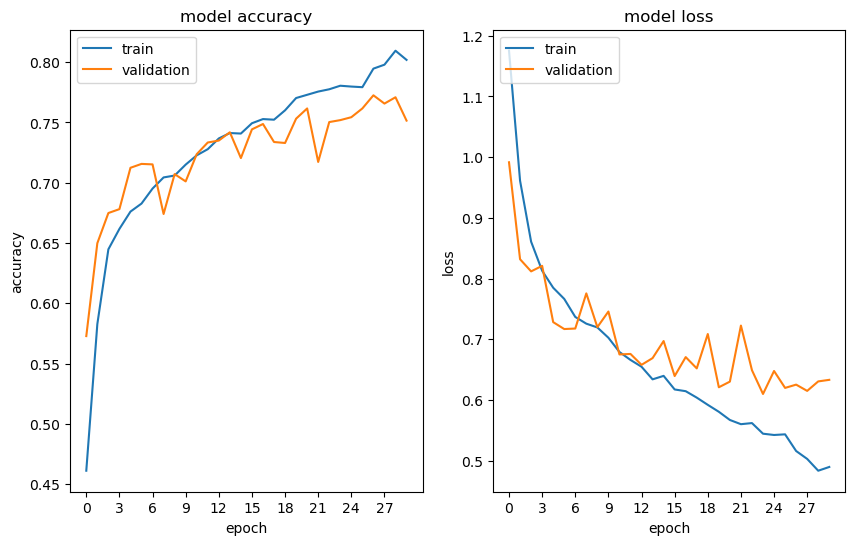

In [36]:
plt.subplots(1,2,figsize = (10,6))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xticks(np.arange(0,30, 3))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xticks(np.arange(0,30,3))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
validation_score = model.evaluate(validation_data)
print('Validation loss:', validation_score[0])
print('Validation accuracy:', validation_score[1])

50/50 [==============================] - 3s 69ms/step - loss: 0.6331 - categorical_accuracy: 0.7515
Validation loss: 0.6330825686454773
Validation accuracy: 0.7515127062797546


In [38]:
test_score = model.evaluate(test_data)
print('Test loss', test_score[0])
print('Test accuracy:', test_score[1])

1/1 [==============================] - 0s 2ms/step - loss: 0.6956 - categorical_accuracy: 0.7247
Test loss 0.6955780982971191
Test accuracy: 0.7246991991996765


In [40]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

In [42]:
predictions = model.predict_classes(X)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [43]:
predictions

array([1, 3, 0, ..., 2, 3, 3], dtype=int64)

In [44]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
'''
y_classes = {
    [1.,0.,0.,0.]: 0,
    [0.,1.,0.,0.]: 1,
    [0.,0.,1.,0.]: 2,
    [0.,0.,0.,1.]: 3
}
'''
# This returns a value error, but the idea of essentially mapping our y to match the formating of our
# predictions will still be essential if we wish to build a good confusion matrix

In [45]:
y = np.ndarray.tolist(y)

In [46]:
y_true = []
for i in range(len(y)):
    if y[i] == [1.,0.,0.,0.]:
        y_true.append(0)
    if y[i] == [0.,1.,0.,0.]:
        y_true.append(1)
    if y[i] == [0.,0.,1.,0.]:
        y_true.append(2)
    if y[i] == [0.,0.,0.,1.]:
        y_true.append(3)

In [47]:
data = {'predictions': predictions,
       'true_values': y_true}

In [48]:
df = pd.DataFrame(data = data)
df.head(10)

,predictions,true_values
0,1,0
1,3,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [49]:
cf_matrix = confusion_matrix(y_true, predictions)
cf_matrix

array([[ 62,   6,   2,   9],
       [ 12, 104,  26,  33],
       [ 16,  94, 745, 141],
       [  4,  20,  26, 113]], dtype=int64)

<Figure size 3000x3000 with 0 Axes>

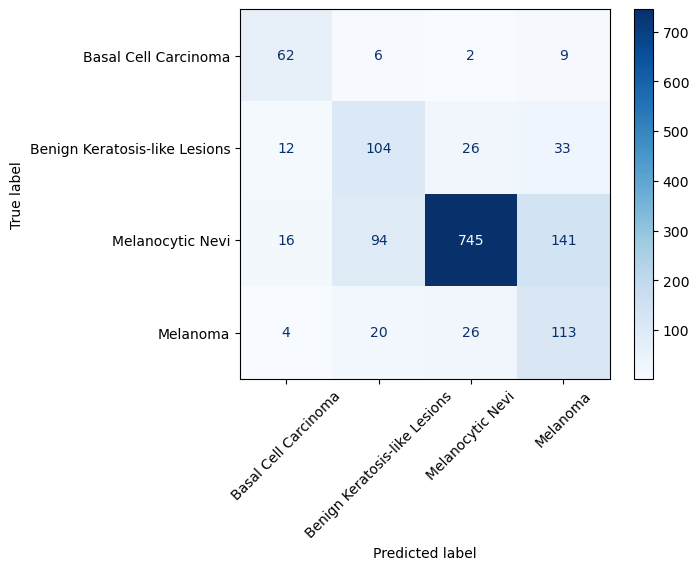

In [50]:
plt.figure(figsize=(30,30))
labels = ["Basal Cell Carcinoma","Benign Keratosis-like Lesions","Melanocytic Nevi","Melanoma"]
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

In [55]:
report = classification_report(y_true, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.56      0.78      0.65        79
           1       0.44      0.69      0.54       175
           2       0.95      0.72      0.82       996
           3       0.38      0.64      0.48       163

    accuracy                           0.71      1413
   macro avg       0.58      0.71      0.62      1413
weighted avg       0.80      0.71      0.73      1413



As can be seen from our confusion matrix and classification report, this initial model did fairly well at classifying our data. We achieved an overall accuracy of ~71%, and all of our categories had the majority of their images get correctly classified. With that, let us take what we have learned from this model, as well as what we have learned from our binary classification models, and attempt to improve upon it.

In [56]:
model.save_weights('model.categorical_preliminary')

In [57]:
model.save("Capstone Categorical Preliminary")

INFO:tensorflow:Assets written to: Capstone Categorical\assets


# 5. Modifying Our Model for Improvement

While our previous model performed fairly well on our training set, and continued to improve its metrics on this dataset, we can see in our model's history that our validation set began to decline towards the end of our training. Unlike with our initial binary classification model, this model appears to only begin to overfit by approximately the 25th epoch, meaning that our overfitting for this classification problem is not as significant. Therefore, while adding two dropout layers was nessassary in order to prevent overfitting over 60 epochs on our binary classification model, I will first try to add just a single dropout layer in addition to the dropout layer which was already present in our original model. As is discussed above, dropout layers are very layers in terms of preventing overfitting.

In [58]:
input_shape = (75, 100, 3)
def prepare_model(Transfer=None):
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu', input_shape=input_shape))            
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dropout(0.5)) #adding this dropout layer helps to prevent overfitting
    model.add(Dense(4, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=[CategoricalAccuracy()])
    print(model.summary())
    return model

In [59]:
model = prepare_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 73, 98, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 49, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 18, 24, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 18, 24, 64)        36928     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 12, 64)         0         
_________________________________________________________________
dense_15 (Dense)             (None, 9, 12, 64)        

In [60]:
model.reset_metrics

<bound method Model.reset_metrics of <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000230DEFADC10>>

In [61]:
history_2 = model.fit(train_data,
                    epochs=60,
                     validation_data= validation_data,
                     callbacks=[tensorboard_callback])

Epoch 1/60
232/232 [==============================] - 53s 230ms/step - loss: 1.1927 - categorical_accuracy: 0.4547 - val_loss: 1.0641 - val_categorical_accuracy: 0.5478
Epoch 2/60
232/232 [==============================] - 52s 223ms/step - loss: 1.0345 - categorical_accuracy: 0.5514 - val_loss: 0.9599 - val_categorical_accuracy: 0.5801
Epoch 3/60
232/232 [==============================] - 54s 231ms/step - loss: 0.9603 - categorical_accuracy: 0.5836 - val_loss: 0.8721 - val_categorical_accuracy: 0.6329
Epoch 4/60
232/232 [==============================] - 54s 233ms/step - loss: 0.8932 - categorical_accuracy: 0.6217 - val_loss: 0.8996 - val_categorical_accuracy: 0.6047
Epoch 5/60
232/232 [==============================] - 54s 234ms/step - loss: 0.8626 - categorical_accuracy: 0.6437 - val_loss: 0.8145 - val_categorical_accuracy: 0.6519
Epoch 6/60
232/232 [==============================] - 54s 232ms/step - loss: 0.8355 - categorical_accuracy: 0.6538 - val_loss: 0.7957 - val_categorical_acc

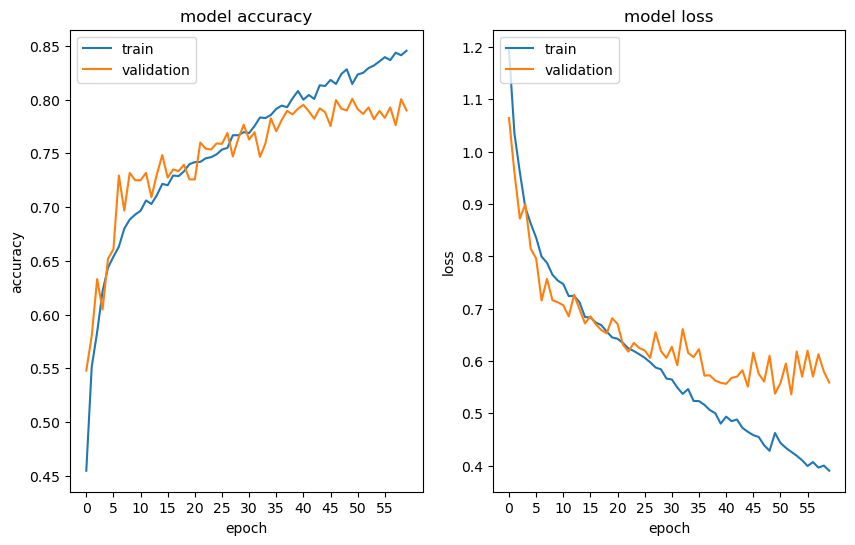

In [64]:
plt.subplots(1,2,figsize = (10,6))

plt.subplot(1,2,1)
plt.plot(history_2.history['categorical_accuracy'])
plt.plot(history_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xticks(np.arange(0,60, 5))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xticks(np.arange(0,60,5))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

While it appears that our model experiences some overfitting during our later epochs, our validation loss and validation accuracy do no appear to be hurt by this. For this reason, this appears to be an acceptable final model for consideration. While our model appears to not have done very much meaningful learning over the course of its last 20 or so epochs, it still seems to have outperformed our previous iterration of this model. Let us verify this by testing this model's performance in predicting our testing dataset.

In [55]:
validation_score = model.evaluate(validation_data)
print('Validation loss:', validation_score[0])
print('Validation accuracy:', validation_score[1])

50/50 [==============================] - 3s 69ms/step - loss: 0.5570 - categorical_accuracy: 0.7882
Validation loss: 0.5570142269134521
Validation accuracy: 0.7882210612297058


In [56]:
test_score = model.evaluate(test_data)
print('Test loss', test_score[0])
print('Test accuracy:', test_score[1])

1/1 [==============================] - 0s 998us/step - loss: 0.6934 - categorical_accuracy: 0.7410
Test loss 0.6933966279029846
Test accuracy: 0.7409766316413879


In [21]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

In [23]:
predictions = model.predict_classes(X)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [24]:
predictions

array([0, 0, 0, ..., 2, 3, 3], dtype=int64)

In [25]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [26]:
'''
y_classes = {
    [1.,0.,0.,0.]: 0,
    [0.,1.,0.,0.]: 1,
    [0.,0.,1.,0.]: 2,
    [0.,0.,0.,1.]: 3
}
'''
# This returns an error, but the idea of essentially mapping our y to match the formating of our
# predictions will still be essential if we wish to build a good confusion matrix

'\ny_classes = {\n    [1.,0.,0.,0.]: 0,\n    [0.,1.,0.,0.]: 1,\n    [0.,0.,1.,0.]: 2,\n    [0.,0.,0.,1.]: 3\n}\n'

In [27]:
y = np.ndarray.tolist(y)

In [28]:
y_true = []
for i in range(len(y)):
    if y[i] == [1.,0.,0.,0.]:
        y_true.append(0)
    if y[i] == [0.,1.,0.,0.]:
        y_true.append(1)
    if y[i] == [0.,0.,1.,0.]:
        y_true.append(2)
    if y[i] == [0.,0.,0.,1.]:
        y_true.append(3)

In [29]:
cf_matrix = confusion_matrix(y_true, predictions)
cf_matrix

array([[ 63,   6,   4,   6],
       [ 20, 102,  21,  32],
       [ 27,  75, 776, 118],
       [  9,  24,  24, 106]], dtype=int64)

<Figure size 3000x3000 with 0 Axes>

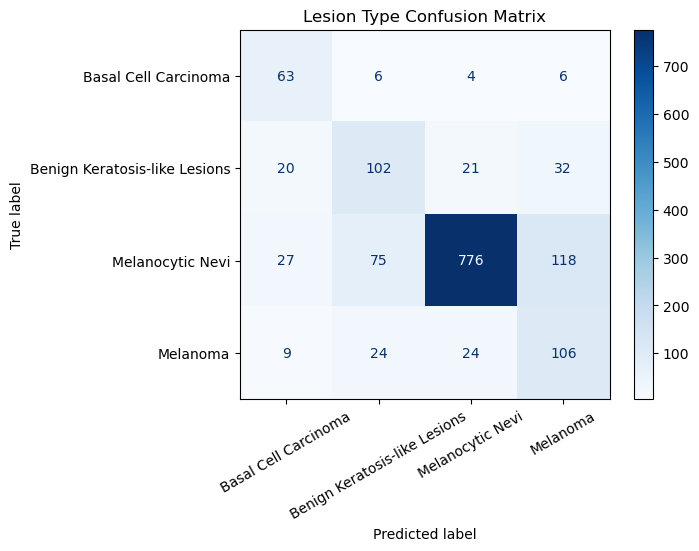

In [32]:
plt.figure(figsize=(30,30))
labels = ["Basal Cell Carcinoma","Benign Keratosis-like Lesions","Melanocytic Nevi","Melanoma"]
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Lesion Type Confusion Matrix")
plt.xticks(rotation=30)
plt.show()

In [75]:
report = classification_report(y_true, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        79
           1       0.49      0.58      0.53       175
           2       0.94      0.78      0.85       996
           3       0.40      0.65      0.50       163

    accuracy                           0.74      1413
   macro avg       0.59      0.70      0.63      1413
weighted avg       0.80      0.74      0.76      1413



This model, having run over 60 epochs, clearly has the best performance out of all of our models considered so far. Our model reached an overall accuracy of ~74.1%. Additionally, our weighted averages for our model are fairly good, including a precision of 0.8, a recall of 0.74, and an f1-score of 0.76. These are not as good as our metrics on our binary classification, but they are big improvements on our first model nonetheless. That having been said, there is still more room for potential improvement, as this final model is still the result of some overfitting during our later training epochs.

In [76]:
model.save_weights('model.categorical_final')

In [77]:
model.save("Capstone Categorical Final")

INFO:tensorflow:Assets written to: Capstone Categorical Final\assets


# Conclusion

In this notebook, we utilized image data which has been balanced and partitions between our training/validation sets and our testing set to build two CNN models, of which the second model outperformed the first. While our final model performed quite well on the dataset, there are always more opportunities for improvement, and moving forward, we should continue to look for new, innovative ways to ensure that our next model itteration is better than the last